In [1]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [12]:
L = 5
Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 2*int(format(j, '0{}b'.format(L))[i])-1
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 2*int(format(j, '0{}b'.format(L))[i])-1 
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

# Exact time evolution

In [13]:
H = sum([Heis[i][(i+1)%L] for i in range(L)]) / 4

# e, v = LA.eig(np.array(H.toarray())) # to dense matrix
e, v = eigs(H, 30)

# ind = e.argsort()
# e = e[idx]
# v = v[:, idx]
# np.conj(v.T) @ H @ v - np.diag(e), decimals=3)

In [14]:
tf = 50
dt = tf / 200
Nt = int(tf / dt)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c-1]
init = UnitVector(int(''.join(c), 2))

In [15]:
revos = [np.zeros(2**L) for i in range(Nt+1)]
revos[0] = init
for i in range(Nt):
    revos[i+1] = expm(-1j * H * dt) @ revos[i]

In [16]:
Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ Sz[0] @ revos[i] / 2)

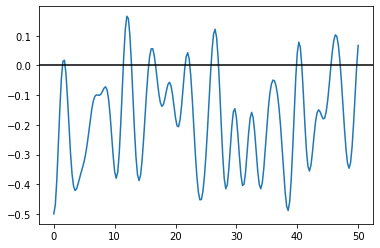

In [17]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

# Trotter Evolution

In [18]:
def TrotterEvolve(tf, nt, init):
    dt = tf / nt
    UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L, 2)]) / 4) # since Python indices start at 0, this is actually even
    UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4) # since Python indices start at 0, this is actually the odd indices
    UTrotter = UEven @ UOdd
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

In [19]:
TrotterFixStepList = [init]
for i in range(Nt):
    TrotterFixStepList.append(TrotterEvolve((i+1)*dt, 10, init))
TrotterFixStepSz = []
for i in range(len(TrotterFixStepList)):
    TrotterFixStepSz.append(np.conj(TrotterFixStepList[i]) @ Sz[0] @ TrotterFixStepList[i] / 2)

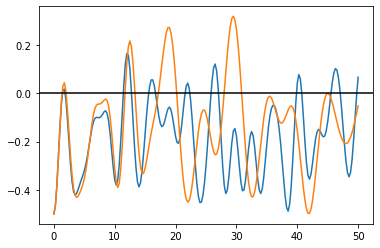

In [20]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
plt.axhline(y=0, color='k')

# Ansatz

In [33]:
p = 3
def Ansatz(params):
    # check for correct length of params
    psi_ansz = init
    for i in range(p): # len(params) // L
        for j in range(0, L, 2):
            # odd first, then even. Apply to left
            psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        for j in range(1, L, 2):
            psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
    return psi_ansz

def Fidelity(x, target):
    psi_ansz = Ansatz(x)
    return 1 - abs(np.conj(target) @ psi_ansz)

In [41]:
# VarSzList = []
# for i in range(1, len(revos)):
#     init_params = np.random.uniform(0, 2*np.pi, L*p)
#     sol = minimize(Fidelity, init_params, args=(revos[i]), method='SLSQP')
#     bar = Ansatz(sol.x)
#     VarSzList.append(np.conj(bar) @ Sz[0] @ bar / 2)

#     if (i % 10 == 0):
#         print(i)

In [ ]:
plt.plot([i*dt for i in range(len(revos))], Szt, label='Exact')
# plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
plt.plot([i*dt for i in range(len(VarSzList))], VarSzList, label='Ansatz p=2')
plt.legend()
plt.axhline(y=0, color='k')

In [40]:
init_params = np.random.uniform(0, 2*np.pi, L*p)
sol = minimize(Fidelity, init_params, args=(revos[-1]), method='SLSQP')
sol

     fun: 0.0003686216903828754
     jac: array([-5.73024154e-05, -3.36296856e-04,  2.23517418e-08,  9.07503068e-04,
       -2.07126141e-06,  3.38494778e-04, -2.94655561e-04, -9.94212925e-04,
        3.88912857e-04,  1.67362392e-04, -1.63517892e-04,  4.59872186e-04,
        6.41271472e-05, -2.07319856e-04,  1.22986734e-04])
 message: 'Optimization terminated successfully.'
    nfev: 607
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([5.89064785, 2.31055907, 5.6751349 , 5.34855614, 3.46930768,
       5.92504154, 4.55683575, 1.14305311, 4.24714365, 2.45407623,
       2.12013691, 4.76930443, 4.39375022, 3.56582655, 3.62119364])